# Data Import

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
pd.options.display.max_rows = 300
import math
import datetime as dt
from tableone import TableOne, load_dataset
import itertools
import random
import scipy.stats as stats
import seaborn as sns

/home/hanl/miniconda3/envs/mytensor/lib/python3.9/site-packages/scipy/__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "


In [ ]:
df_type = pd.read_csv("/public/hanl/jupyter_dir/kidney_sepsis_penotype_v3/03.eICU_SAKI_trajCluster/df_mixAK_fea4_C3_eicu.csv")
df_type_filt = df_type.loc[:,["stay_id","groupHPD"]]
df_type_filt = df_type_filt.drop_duplicates()
all_lst = df_type_filt.stay_id.unique().tolist()
print("The number of included patients:",len(all_lst))

df_type_filt["groupHPD"].value_counts()

/home/hanl/miniconda3/envs/mytensor/lib/python3.9/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/home/hanl/miniconda3/envs/mytensor/lib/python3.9/site-packages/ipykernel/pylab/backend_inline.py:164: DeprecationWarning: `configure_inline_support` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.configure_inline_support()`
  configure_inline_support(ip, backend)


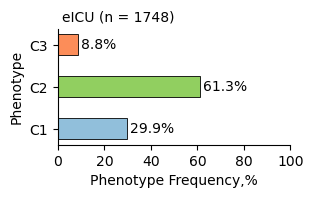

In [3]:
tmp = pd.DataFrame(df_type_filt["groupHPD"].value_counts()).reset_index()
tmp.columns = ["groupHPD","count"]
tmp["count_all"] = len(all_lst)
tmp["Percentage"] = round(tmp["count"]/tmp["count_all"]*100,1)

plt.figure(figsize=(3,1.5))
ax=plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.barh(tmp["groupHPD"].tolist(), tmp["Percentage"].tolist(),color=["#91cf60","#91bfdb","#fc8d59"],ec='black', ls='-', lw=0.6,height=0.5)
plt.xlabel("Phenotype Frequency,%")
plt.ylabel("Phenotype")
plt.yticks([1,2,3],[ 'C1', 'C2', 'C3'])
plt.xlim([0,100])
plt.text(tmp[tmp["groupHPD"]==1]["Percentage"].tolist()[0]+1,1,str(tmp[tmp["groupHPD"]==1]["Percentage"].tolist()[0])+"%",verticalalignment="center")
plt.text(tmp[tmp["groupHPD"]==2]["Percentage"].tolist()[0]+1,2,str(tmp[tmp["groupHPD"]==2]["Percentage"].tolist()[0])+"%",verticalalignment="center")
plt.text(tmp[tmp["groupHPD"]==3]["Percentage"].tolist()[0]+1,3,str(tmp[tmp["groupHPD"]==3]["Percentage"].tolist()[0])+"%",verticalalignment="center")

plt.title("eICU (n = 1748)",fontsize=10,horizontalalignment="right")
plt.savefig("./result/eICU_phenotype_frequency.pdf")
plt.show()


# Feature Description - Three groups
- base info
    age
    gender
    weight
    los
    first_careunit

- labboratory vallues
    eGFR at baseline(ml/min/1.73m2)
    creatinine at baseline
    Maximum serum creatinine
    Urine Output
    
- AKI 
    first kdigo stages
    max kdigo stages

- ICU events（septic shock）
    Mechanical ventilation
    Liquid resuscitation
    RRT
    kidney transplantation
    
- primary outcome
    28-dmortality
    renal recovery
    SAPS II score
    
- comorbidities
    Hypertension 
    Congestive heart failure 
    Diabetes mellitus 
    Liver disease 
    Peripheral vascular disease
    ...

In [ ]:
# Add AKI at the initial diagnosis stage
df_aki_first = pd.read_csv("/public/hanl/jupyter_dir/kidney_sepsis_penotype_v3/00.data_eicu/disease_definition/AKI/eicu_sk_first_and_max_stage.csv")
df_aki_first = df_aki_first[["stay_id","first_aki_onset","first_aki_stage","max_aki_stage","aki_endstage","aki_endstage_H7D"]]
df_demo_base_add = pd.merge(df_type_filt, df_aki_first, how="left", on = "stay_id")
print(df_demo_base_add.groupHPD.value_counts())

# AKI course
df_time = pd.read_csv("/public/hanl/jupyter_dir/kidney_sepsis_penotype_v3/00.data_eicu//disease_definition/AKI/eicu_sk_first_and_max_stage.csv")
df_time["AKI_course"] = (df_time["aki_endtime_H7D"] - df_time["first_aki_onset"])/24
df_time = df_time[["stay_id","AKI_course"]]
df_demo_base_add = pd.merge(df_demo_base_add, df_time, how="left", on = "stay_id")

df_demo = pd.read_csv("/public/hanl/jupyter_dir/kidney_sepsis_penotype_v3/00.data_eicu//feature_data/df_eicu_basicinfo.csv")
df_demo = pd.merge(df_demo, df_aki_first[["stay_id","first_aki_onset"]], how="left", on = "stay_id")
df_demo["icu_stay_days_after_SAAKI"] = (df_demo["outtime"] - df_demo["first_aki_onset"])/24
df_demo = df_demo[['stay_id', 'gender', 'discharge_location', 'icu_expire_flag','first_unittype','age',
       'hospital_expire_flag', 'ethnicity', 'height', 'weight','icu_stay_days','icu_stay_days_after_SAAKI']]
df_demo_base_add = pd.merge(df_demo_base_add, df_demo, how="left", on = "stay_id")
df_demo_base_add = df_demo_base_add.drop_duplicates()

# Add baseline creatinine
df_base_crea = pd.read_csv("/public/hanl/jupyter_dir/kidney_sepsis_penotype_v3//00.data_eicu/disease_definition/AKI//df_base_crea.csv")
df_base_crea.columns = ["stay_id","baseline_Scr"]
df_demo_base_add = pd.merge(df_demo_base_add, df_base_crea, how="left", on="stay_id")

# Add peak and discharge creatinine
df_peak_discharge = pd.read_csv("/public/hanl/jupyter_dir/kidney_sepsis_penotype_v3/00.data_eicu//disease_definition/AKI/df_peak_discharge.csv")
df_demo_base_add = pd.merge(df_demo_base_add, df_peak_discharge, how="left", on="stay_id")
print(len(df_demo.stay_id.unique()))

# Add the diagnostic criteria for AKI
df_criteria = pd.read_csv("/public/hanl/jupyter_dir/kidney_sepsis_penotype_v3/00.data_eicu/disease_definition/AKI/AKI_diagnose_criteria.csv")
df_demo_base_add = pd.merge(df_demo_base_add, df_criteria, how="left", on="stay_id")

# Add lifesupport
df_support = pd.read_csv("/public/hanl/jupyter_dir/kidney_sepsis_penotype_v3/00.data_eicu/treatment/eicu_lifesupport.csv")
df_demo_base_add = pd.merge(df_demo_base_add, df_support, how="left", on="stay_id")
df_demo_base_add[["is_vaso", "is_mv", "is_rrt"]] = df_demo_base_add[["is_vaso", "is_mv", "is_rrt"]].fillna(0)

# mortality rate
df_admit = pd.read_csv("sk_survival.csv")
df_admit = df_admit.loc[:,["stay_id",  "mortality_28d"]]
df_demo_base_add = pd.merge(df_admit, df_demo_base_add, how="inner", on = "stay_id")

# How long aki occur after sepsis
df_time = pd.read_csv("/public/hanl/jupyter_dir/kidney_sepsis_penotype_v3/00.data_eicu//disease_definition/AKI/eicu_saki_event_time.csv")
df_time = df_time[df_time.stay_id.isin(all_lst)]
df_time["los_saki_minus_sepsis"] = (df_time["aki_onset"] - df_time["sepsis_onset"])/1
df_time["los_aki_minus_intime"] = (df_time["aki_onset"] - df_time["intime"])/1
df_time["los_sepsis_minus_intime"] = (df_time["sepsis_onset"] - df_time["intime"])/1
df_demo_base_add = pd.merge(df_demo_base_add, df_time, how="left", on = "stay_id")

#Add the SA-AKI type
df_event = pd.read_csv("/public/hanl/jupyter_dir/kidney_sepsis_penotype_v3/00.data_eicu/disease_definition/AKI/eicu_saki_event_time.csv")
df_event = df_event[df_event.stay_id.isin(all_lst)]
df_event["los_sepsis_saaki"] = (df_event["saki_onset"] - df_event["sepsis_onset"])/1
df_event.loc[df_event["los_sepsis_saaki"]<=48,"SA-AKI_type"] = "Early SA-AKI"
df_event.loc[df_event["los_sepsis_saaki"]>48,"SA-AKI_type"] = "Late SA-AKI"
df_event = df_event[['stay_id', 'los_sepsis_saaki','SA-AKI_type']]
df_demo_base_add = pd.merge(df_event, df_demo_base_add, how="inner", on = "stay_id")


# Comorbidity
df_icd = pd.read_csv("/public/hanl/jupyter_dir/kidney_sepsis_penotype_v3/00.data_eicu/diag_icd/df_eicu_diag_icd.csv")
df_demo_base_add = pd.merge(df_demo_base_add, df_icd, how="left",on="stay_id")
df_demo_base_add[['Acidosis', 'Cardiogenic shock', 'Congestive heart failure',
       'Diabetes', 'Hepatic', 'Hypertension', 'Hypovolemic shock',
       'Myocardial infarct', 'Respiratory failure', 'Septic shock','cardiovascular', 'gastrointestinal', 'neurologic', 'oncology',
       'pulmonary', 'renal']] = df_demo_base_add[['Acidosis', 'Cardiogenic shock', 'Congestive heart failure',
       'Diabetes', 'Hepatic', 'Hypertension', 'Hypovolemic shock',
       'Myocardial infarct', 'Respiratory failure', 'Septic shock','cardiovascular', 'gastrointestinal', 'neurologic', 'oncology',
       'pulmonary', 'renal']].fillna(0)
df_demo_base_add[df_icd.columns.tolist()] = df_demo_base_add[df_icd.columns.tolist()].astype("int")

# Draw a table
columns = ['gender', 'age', 'height', 'weight','ethnicity','first_unittype',
'hospital_expire_flag', 'icu_expire_flag','icu_stay_days','icu_stay_days_after_SAAKI','AKI_course','discharge_location',"SA-AKI_type",
       'baseline_Scr','Peak_Scr','Discharge_Scr',  "first_aki_stage","max_aki_stage","aki_endstage","aki_endstage_H7D","AKI_criteria",
           'Acidosis', 'Cardiogenic shock', 'Congestive heart failure',
       'Diabetes', 'Hepatic', 'Hypertension', 'Hypovolemic shock',
       'Myocardial infarct', 'Respiratory failure', 'Septic shock','cardiovascular', 'gastrointestinal', 'neurologic', 'oncology',
       'pulmonary', 'renal',
          'is_vaso', 'is_mv', 'is_rrt','los_sepsis_minus_intime','los_aki_minus_intime','los_saki_minus_sepsis']

categorical = ['gender',  'ethnicity','first_unittype',
    'hospital_expire_flag', 'icu_expire_flag', 'discharge_location',"SA-AKI_type",
    "first_aki_stage","max_aki_stage","aki_endstage","aki_endstage_H7D","AKI_criteria",
    'Acidosis', 'Cardiogenic shock', 'Congestive heart failure',
       'Diabetes', 'Hepatic', 'Hypertension', 'Hypovolemic shock',
       'Myocardial infarct', 'Respiratory failure', 'Septic shock','cardiovascular', 'gastrointestinal', 'neurologic', 'oncology',
       'pulmonary', 'renal',
    'is_vaso', 'is_mv', 'is_rrt']
nonnormal = ['age', 'height', 'weight','icu_stay_days','los_sepsis_minus_intime','los_aki_minus_intime','los_saki_minus_sepsis','icu_stay_days_after_SAAKI','AKI_course','baseline_Scr','Peak_Scr','Discharge_Scr']
df_demo_stat = TableOne(df_demo_base_add, columns=columns, nonnormal=nonnormal, categorical=categorical, groupby = ["groupHPD"], pval=True)

df_demo_stat = pd.DataFrame(df_demo_stat.tableone).reset_index()
df_demo_stat = df_demo_stat.droplevel(level=0, axis=1)
df_demo_stat = df_demo_stat.loc[:,['','Overall', '1', '2', '3', 'P-Value']]
df_demo_stat.columns = ['feature', 'type','Overall', 'C1', 'C2', 'C3', 'P-Value']
df_demo_stat.to_csv("./result/eICU_clusters_characteristics.csv",index=False)
df_demo_stat

/home/hanl/miniconda3/envs/mytensor/lib/python3.9/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


groupHPD
2    869
1    423
3    125
Name: count, dtype: int64
200859


/home/hanl/miniconda3/envs/mytensor/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2003: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  dtyp = np.find_common_type([x.dtype, np.float64], [])
/home/hanl/miniconda3/envs/mytensor/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2003: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  dtyp = np.find_common_type([x.dtype, np.float64], [])
/home/hanl/miniconda3/envs/mytensor/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2003: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://nu

/home/hanl/miniconda3/envs/mytensor/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2003: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  dtyp = np.find_common_type([x.dtype, np.float64], [])
/home/hanl/miniconda3/envs/mytensor/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2003: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  dtyp = np.find_common_type([x.dtype, np.float64], [])
/home/hanl/miniconda3/envs/mytensor/lib/python3.9/site-packages/tableone/tableone.py:921: FutureWarning: The provided callable <function mean at 0x2b4c8ffc7160> is currently using DataFrameGroupBy.mean. In a future version of pa

,feature,type,Overall,C1,C2,C3,P-Value
0,n,,1417,423,869,125,
1,"gender, n (%)",F,698 (49.3),217 (51.3),418 (48.1),63 (50.4),0.539
2,"gender, n (%)",M,719 (50.7),206 (48.7),451 (51.9),62 (49.6),
3,"age, median [Q1,Q3]",,"67.0 [55.0,78.0]","73.0 [61.0,82.0]","65.0 [53.0,76.0]","62.0 [49.0,75.0]",<0.001
4,"height, median [Q1,Q3]",,"168.0 [160.0,177.8]","168.0 [160.0,177.8]","168.0 [162.0,177.8]","167.8 [162.5,175.3]",0.737
5,"weight, median [Q1,Q3]",,"78.6 [64.0,96.9]","79.3 [65.0,97.5]","77.2 [63.5,95.8]","81.3 [68.4,98.7]",0.310
6,"ethnicity, n (%)",Asian,10 (0.7),3 (0.7),3 (0.3),4 (3.2),0.001
7,"ethnicity, n (%)",Black,145 (10.2),54 (12.8),77 (8.9),14 (11.2),
8,"ethnicity, n (%)",Hispanic,119 (8.4),40 (9.5),71 (8.2),8 (6.4),
9,"ethnicity, n (%)",Other/Unknown,67 (4.7),20 (4.7),35 (4.0),12 (9.6),


In [5]:
df_demo_stat[df_demo_stat["type"]==str(1)].loc[:,['feature','Overall', 'C1', 'C2', 'C3', 'P-Value']]


/home/hanl/miniconda3/envs/mytensor/lib/python3.9/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,feature,Overall,C1,C2,C3,P-Value
35,"first_aki_stage, n (%)",759 (53.6),254 (60.0),429 (49.4),76 (60.8),0.003
42,"aki_endstage, n (%)",127 (9.0),67 (15.8),41 (4.7),19 (15.2),
46,"aki_endstage_H7D, n (%)",71 (5.0),35 (8.3),19 (2.2),17 (13.6),
53,"Acidosis, n (%)",115 (8.1),37 (8.7),61 (7.0),17 (13.6),
55,"Cardiogenic shock, n (%)",14 (1.0),3 (0.7),7 (0.8),4 (3.2),
57,"Congestive heart failure, n (%)",178 (12.6),76 (18.0),87 (10.0),15 (12.0),
59,"Diabetes, n (%)",250 (17.6),96 (22.7),135 (15.5),19 (15.2),
61,"Hepatic, n (%)",92 (6.5),34 (8.0),41 (4.7),17 (13.6),
63,"Hypertension, n (%)",275 (19.4),86 (20.3),170 (19.6),19 (15.2),
65,"Hypovolemic shock, n (%)",21 (1.5),10 (2.4),10 (1.2),1 (0.8),


# Prognosis

## 28d mortality 

In [ ]:
# Data Preparation
df_admit = pd.read_csv("/public/hanl/jupyter_dir/kidney_sepsis_penotype_v3/00.data_eicu//feature_data/df_eicu_basicinfo.csv")
df_admit = df_admit[['stay_id', f'dischtime', 'hospital_expire_flag']]

data_dir = "/public/hanl/jupyter_dir/kidney_sepsis_penotype_v3/00.data_eicu/disease_definition/AKI/"
infile = data_dir + "eicu_saki_event_time.csv"
df_time = pd.read_csv(infile)
df_time = df_time[df_time["stay_id"].isin(all_lst)]
df_time = df_time[["stay_id","saki_onset"]]

df_admit = pd.merge(df_admit,df_time,how="inner",on="stay_id")
df_admit["hospital_survival_day"] = (df_admit["dischtime"] - df_admit["saki_onset"])/24
df_admit["hospital_survival_day_"] = (df_admit["dischtime"] - df_admit["saki_onset"])/24

df_admit = df_admit.loc[:,['stay_id','hospital_survival_day',"hospital_expire_flag","hospital_survival_day_"]]
df_admit["hospital_survival_day"] = round(df_admit["hospital_survival_day"],0)
df_admit["hospital_survival_day_"] = round(df_admit["hospital_survival_day_"],0)
df_admit = pd.merge(df_admit, df_type_filt,how="inner",on="stay_id")
df_admit = df_admit.drop_duplicates()

# 28 day mortality
df_admit["mortality_28d"] = df_admit["hospital_expire_flag"]
df_admit["survival_28day"] = df_admit["hospital_survival_day"]
df_admit.loc[(df_admit["hospital_survival_day"]>=30), "mortality_28d"] = 0

df_admit["mortality_7d"] = df_admit["hospital_expire_flag"]
df_admit["survival_7day"] = df_admit["hospital_survival_day"] 
df_admit.loc[(df_admit["hospital_survival_day"]>=7), "mortality_7d"] = 0

df_admit["hospital_survival_day"].fillna(df_admit["hospital_survival_day_"], inplace=True)
df_admit["survival_7day"].fillna(df_admit["hospital_survival_day_"], inplace=True)
df_admit["survival_28day"].fillna(df_admit["hospital_survival_day_"], inplace=True)

df_admit.loc[df_admit["survival_28day"]>30, "survival_28day"] = 30
df_admit.loc[df_admit["survival_7day"]>7, "survival_7day"] = 7

df_admit.to_csv("sk_survival.csv", index=False)

/home/hanl/miniconda3/envs/mytensor/lib/python3.9/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-6-2c7047b9cf66>:30: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_admit["hospital_survival_day"].fillna(df_admit["hospital_survival_day

In [ ]:
# see R

/home/hanl/miniconda3/envs/mytensor/lib/python3.9/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Vertical Change
- The standard deviation is the average variation in a dataset. It on average indicates how far each data point differs from the average value. The larger the standard deviation, the greater the variability of the data set
- Variance represents the distribution range of the data set, but it is an abstract number. It reflects the degree of dispersion in the dataset. The more dispersed the data is, the greater the relationship between variance and mean will be.

In [8]:
fea_min_dict = {'heart_rate':60, 'sbp':90, 'dbp':60, 'mbp':70,'resp_rate':12, 'temperature':35.8,'glucose':72,
                'bicarbonate':22, 'ph':7.35, 'baseexcess':-2,'totalco2':22, 'lactate':0.5,  'pco2':35, 'aniongap':3,
                'spo2':95, 'fio2':21, 'aado2':5, 'pao2fio2ratio':300,'po2':75, 'so2':94,
                'alt':7, 'alp':40, 'ast':8, 'bilirubin_total':0.1,  'albumin':3.5,
                'chloride':100, 'potassium':3.7,'calcium':8.5, 'sodium':136,
            'inr':0.8, 'pt':11, 'ptt':25, 
                'sofa':0, 'respiration_sofa':0,'coagulation_sofa':0, 'liver_sofa':0, 'cardiovascular_sofa':0, 'cns_sofa':0,
                 'mch':27.5, 'mchc':32, 'mcv':80, 'platelet':150, 'rbc':4.2, 'rdw':12, 'hematocrit':36, 'hemoglobin':12, 'wbc':5
           }
fea_max_dict = {'heart_rate':100, 'sbp':120, 'dbp':80, 'mbp':105,'resp_rate':20, 'temperature':36.9,'glucose':180,
                 'bicarbonate':29, 'ph':7.45, 'baseexcess':2,'totalco2':28, 'lactate':1.6,  'pco2':45, 'aniongap':11,
                'spo2':100, 'fio2':100, 'aado2':15, 'pao2fio2ratio':500,'po2':100, 'so2':98,
                'alt':55, 'alp':129, 'ast':48, 'bilirubin_total':1.2,  'albumin':5,
                'chloride':107, 'potassium':5.1,'calcium':10.2, 'sodium':144,
            'inr':1.5, 'pt':17, 'ptt':33, 
             'sofa':2, 'respiration_sofa':2,'coagulation_sofa':2, 'liver_sofa':2, 'cardiovascular_sofa':2, 'cns_sofa':2,
                 'mch':33.2, 'mchc':36, 'mcv':100, 'platelet':450, 'rbc':6.1, 'rdw':15, 'hematocrit':55, 'hemoglobin':17.5, 'wbc':10
           }

/home/hanl/miniconda3/envs/mytensor/lib/python3.9/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Feature change

/home/hanl/miniconda3/envs/mytensor/lib/python3.9/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-9-ae861b6da3b3>:45: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro-" (-> color='r'). The keyword argument will take precedence.
  plt.plot([p[0] for p in mean_points], [p[1] for p in mean_points], 'ro-', linewidth=1,color="#91bfdb")
<ipython-input-9-ae861b6da3b3>:47: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro-" (-> color='r'). The keyword argument will take precedence.
  plt.plot([p[0] for p in mean_points], [p[1] for p in mean_points], 'ro-', linewidth=1,color="#91cf60")
<ipython-input-9-ae861b6d

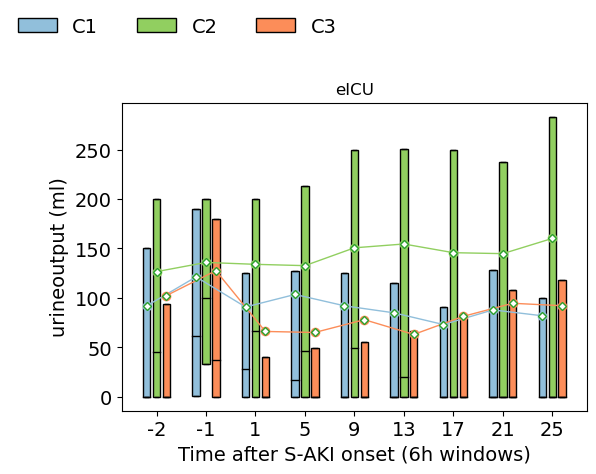

<ipython-input-9-ae861b6da3b3>:45: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro-" (-> color='r'). The keyword argument will take precedence.
  plt.plot([p[0] for p in mean_points], [p[1] for p in mean_points], 'ro-', linewidth=1,color="#91bfdb")
<ipython-input-9-ae861b6da3b3>:47: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro-" (-> color='r'). The keyword argument will take precedence.
  plt.plot([p[0] for p in mean_points], [p[1] for p in mean_points], 'ro-', linewidth=1,color="#91cf60")
<ipython-input-9-ae861b6da3b3>:49: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro-" (-> color='r'). The keyword argument will take precedence.
  plt.plot([p[0] for p in mean_points], [p[1] for p in mean_points], 'ro-', linewidth=1,color="#fc8d59")


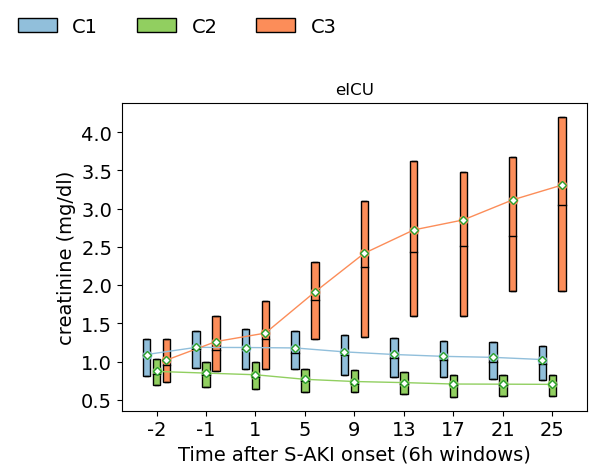

<ipython-input-9-ae861b6da3b3>:45: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro-" (-> color='r'). The keyword argument will take precedence.
  plt.plot([p[0] for p in mean_points], [p[1] for p in mean_points], 'ro-', linewidth=1,color="#91bfdb")
<ipython-input-9-ae861b6da3b3>:47: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro-" (-> color='r'). The keyword argument will take precedence.
  plt.plot([p[0] for p in mean_points], [p[1] for p in mean_points], 'ro-', linewidth=1,color="#91cf60")
<ipython-input-9-ae861b6da3b3>:49: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro-" (-> color='r'). The keyword argument will take precedence.
  plt.plot([p[0] for p in mean_points], [p[1] for p in mean_points], 'ro-', linewidth=1,color="#fc8d59")


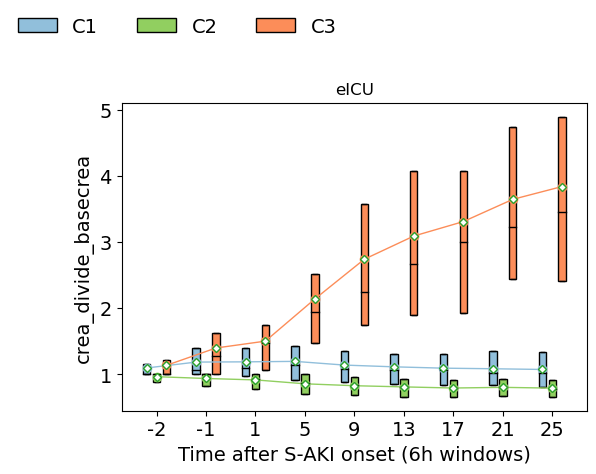

In [ ]:
import matplotlib.pyplot as plt
fea_lst = ["urineoutput", "creatinine","crea_divide_basecrea"] #"bun", "sofa",
lab_dict = {"urineoutput": "urineoutput (ml)",  "creatinine": "creatinine (mg/dl)", "crea_divide_basecrea":"crea_divide_basecrea"}

# fea_lst = [
#'heart_rate', 'sbp', 'dbp', 'mbp','resp_rate', 'temperature','glucose'#,
#'gcs', 'gcs_motor','gcs_verbal', 'gcs_eyes', 'gcs_unable'#,  
# 'bicarbonate', 'ph', 'baseexcess','totalco2', 'lactate',  'pco2', 'aniongap'#,
# 'spo2', 'fio2', 'aado2', 'pao2fio2ratio','po2', 'so2'#, 
#'inr', 'pt', 'ptt', 
# 'alt', 'alp', 'ast', 'bilirubin_total',  'albumin',
#'sofa', 'respiration_sofa','coagulation_sofa', 'liver_sofa', 'cardiovascular_sofa', 'cns_sofa',
# 'chloride', 'potassium','calcium', 'sodium', # 'free_calcium', 
# 'basophils_abs', 'eosinophils_abs', 'lymphocytes_abs', 'monocytes_abs','neutrophils_abs', 'basophils', 'eosinophils', 'lymphocytes','monocytes', 'neutrophils',
# 'mch', 'mchc', 'mcv', 'platelet', 'rbc', 'rdw', 'hematocrit', 'hemoglobin', 'wbc'
#]
for fea in fea_lst:
    df_fea = pd.read_csv("/public/hanl/jupyter_dir/kidney_sepsis_penotype_v3/03.eICU_SAKI_trajCluster/sk_feature_timescale_Fb2_eicu.csv")
    choose_time_lst = [-2,-1,1,5,9,13,17,21,25] #[-2,-1,1,3,5,7,9,11,13,15,17,19,21,23,25,27] #[-2,-1,1,4,7,10,13,16]
    df_fea =  df_fea[df_fea["time"].isin(choose_time_lst)] 
    df = pd.merge(df_type_filt,df_fea, how="inner",on="stay_id")
    df1 = df[df["groupHPD"]==1][[fea,"time"]]
    df2 = df[df["groupHPD"]==2][[fea,"time"]]
    df3 = df[df["groupHPD"]==3][[fea,"time"]]
    dataframes1 = [group[1] for group in df1.groupby('time')]
    dataframes2 = [group[1] for group in df2.groupby('time')]
    dataframes3 = [group[1] for group in df3.groupby('time')]

    fig = plt.figure(figsize=(6,4))
    choose_time_lst_x = range(-1,len(choose_time_lst)-1)
    choose_time_lst1 = [i-0.2 for i in choose_time_lst_x]
    choose_time_lst2 = choose_time_lst_x
    choose_time_lst3 = [i+0.2 for i in choose_time_lst_x]
    medianprops = dict(linestyle='-', linewidth=1, color='black') 
    meanprops = dict(color='b', markersize=4,marker="D",markerfacecolor="white")

    boxprops1 = dict(color='black',facecolor='#91bfdb',edgecolor="black")
    boxprops2 = dict(color='black',facecolor='#91cf60',edgecolor="black")
    boxprops3 = dict(color='black',facecolor='#fc8d59',edgecolor="black")
    pa = plt.boxplot([df[fea] for df in dataframes1],whis=(25,75),showfliers=False,showmeans=True, meanline=False,widths=0.15,boxprops=boxprops1, positions=choose_time_lst1,patch_artist=True,meanprops=meanprops, medianprops=medianprops )
    pb = plt.boxplot([df[fea] for df in dataframes2],whis=(25,75),showfliers=False,showmeans=True, meanline=False,widths=0.15,boxprops=boxprops2,positions=choose_time_lst2,patch_artist=True,meanprops=meanprops, medianprops=medianprops)
    pc = plt.boxplot([df[fea] for df in dataframes3],whis=(25,75),showfliers=False,showmeans=True, meanline=False,widths=0.15,boxprops=boxprops3,positions=choose_time_lst3,patch_artist=True,meanprops=meanprops, medianprops=medianprops )
    # A line graph with added average values
    mean_points = [pa['means'][i].get_xydata()[0] for i in range(len(pa['means']))]
    plt.plot([p[0] for p in mean_points], [p[1] for p in mean_points], 'ro-', linewidth=1,color="#91bfdb")
    mean_points = [pb['means'][i].get_xydata()[0] for i in range(len(pb['means']))]
    plt.plot([p[0] for p in mean_points], [p[1] for p in mean_points], 'ro-', linewidth=1,color="#91cf60")
    mean_points = [pc['means'][i].get_xydata()[0] for i in range(len(pc['means']))]
    plt.plot([p[0] for p in mean_points], [p[1] for p in mean_points], 'ro-', linewidth=1,color="#fc8d59")
    label_lst = ["C1", "C2", "C3"]
    plt.legend([pa["boxes"][0], pb["boxes"][0], pc["boxes"][0]], ["C1", "C2", "C3"], loc= 'lower right',bbox_to_anchor=(0.5,1.16),ncol=3,frameon=False,fontsize=14)

    x_position= choose_time_lst_x
    x_position_fmt=choose_time_lst
    plt.xticks(x_position, x_position_fmt,fontsize=14)
    plt.yticks(fontsize=14)
    plt.title("eICU")
    plt.xlabel('Time after S-AKI onset (6h windows)',fontsize=14)
    plt.ylabel(lab_dict[fea],fontsize=14)
    tit = "./result/eICU_" + fea + ".pdf"
    plt.savefig(tit)
    plt.show()

# Changes of AKI stages at each moment + survival status - 6h

## The change of death at every moment - 6 hours

In [ ]:
df_sur = pd.read_csv("./sk_survival.csv")
df_sur["survival_168H"] = df_sur["survival_28day"] * 4
df_sur = df_sur.loc[:,["stay_id", "groupHPD", "survival_168H","mortality_28d"]]

com_lst = []
for i in df_sur.stay_id.unique().tolist():
    for j in range(-2,29,1):
        com_lst.append([i,j])
df_com = pd.DataFrame(com_lst,columns=["stay_id", "time"])            

df_sur_ = pd.merge(df_com, df_sur, how="inner", on="stay_id")
df_sur_["survival_state"] = 0
df_sur_.loc[(df_sur_["time"]>=df_sur_["survival_168H"])& (df_sur_["mortality_28d"]==0),"survival_state"]  = "A"
df_sur_.loc[(df_sur_["time"]>=df_sur_["survival_168H"])& (df_sur_["mortality_28d"]==1),"survival_state"]  = "D"
df_sur_ = df_sur_.loc[:,["stay_id","time","survival_state"]]
df_sur_.head(2)

/home/hanl/miniconda3/envs/mytensor/lib/python3.9/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-10-b1de25902839>:13: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'A' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_sur_.loc[(df_sur_["time"]>=df_sur_["survival_168H"])& (df_sur_["mortality_28d"]==0),"survival_state"]  = "A"


,stay_id,time,survival_state
0,338080,-2,0
1,338080,-1,0


## Changes of AKI stages at every moment - 6h

In [11]:
select_time_lst = [0,1,5,9,13,17,21,25] #[0,1,2,3,4,5,7,9,11,13,15,20,24,26,27,28]
import math
map_dict ={}
map_dict[0] = "Onset"
for i in range(1,29,1):
    j = "D" + str(math.ceil(i/4)) + "_" + str(i%4)
    map_dict[i] = j.replace("_0","_4")
    
xticks = [ map_dict[i] for i in select_time_lst]
print(xticks)

['Onset', 'D1_1', 'D2_1', 'D3_1', 'D4_1', 'D5_1', 'D6_1', 'D7_1']


/home/hanl/miniconda3/envs/mytensor/lib/python3.9/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# Complete 28 stages
df_stage = pd.read_csv("/public/hanl/jupyter_dir/kidney_sepsis_penotype_v3/00.data_eicu/disease_definition/AKI/eicu_kdigo_stages_based_time.csv")

# Fill in the points without AKI stages records with survival and death
tmp_df = pd.merge(df_stage, df_sur_, how="right", on= ["stay_id","time"])
tmp_df["aki_stage"].fillna(tmp_df["survival_state"],inplace=True)
tmp_df.loc[tmp_df["aki_stage"]=="A","aki_stage"] = 5
tmp_df.loc[tmp_df["aki_stage"]=="D","aki_stage"] = 4

# The number of patients for each category and each class at each time point
df_aki_all = tmp_df
df_aki_all = pd.merge(df_aki_all,df_type_filt, how="inner",on="stay_id")
df_aki_all = df_aki_all.loc[:,['stay_id', 'time', 'aki_stage', 'groupHPD']]
df_aki_all = df_aki_all.groupby(["time","groupHPD","aki_stage"]).agg("count").reset_index()

# Build a complete dataframe # time-2-29
# aki_stage 0-3
# groupHPD 1-3
com_lst = []
for i in range(-2,29,1): # time
    for j in range(0,6,1): # aki_stage
        for k in range(1,4,1): # groupHPD
            com_lst.append([i,j,k])
df_com = pd.DataFrame(com_lst,columns=["time", "aki_stage", "groupHPD"])            
df_aki_all = pd.merge(df_com, df_aki_all, how="left", on=["time","aki_stage", "groupHPD"])
df_aki_all = df_aki_all.fillna(0)

df_stayid_sum = pd.DataFrame(df_type_filt["groupHPD"].value_counts()).reset_index()
df_stayid_sum.columns = [ 'groupHPD', 'stay_id_sum']

df_aki_all_ = pd.merge(df_aki_all, df_stayid_sum, how="inner", on=["groupHPD"])
df_aki_all_["percent"] = round(df_aki_all_["stay_id"]/df_aki_all_["stay_id_sum"]*100,2)
df_aki_all_ = df_aki_all_[df_aki_all_["time"].isin(select_time_lst)]
df1 = df_aki_all_[df_aki_all_["groupHPD"] ==1]
df2 = df_aki_all_[df_aki_all_["groupHPD"] ==2]
df3 = df_aki_all_[df_aki_all_["groupHPD"] ==3]

/home/hanl/miniconda3/envs/mytensor/lib/python3.9/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-12-2dac7e95209d>:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  tmp_df["aki_stage"].fillna(tmp_df["survival_state"],inplace=True)
<ipyth

/home/hanl/miniconda3/envs/mytensor/lib/python3.9/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


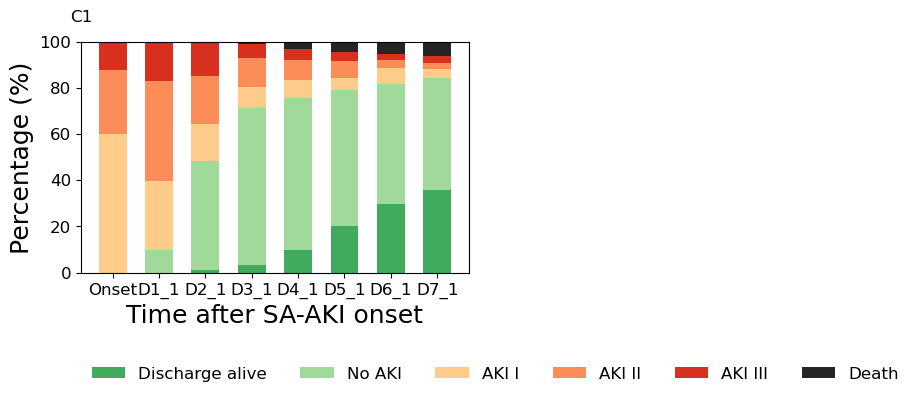

In [13]:
import numpy as npd
import matplotlib.pyplot as plt

plt.figure(figsize=(5,3)) 
ind = df_aki_all_.time.unique().tolist()
ind = sorted(range(len(ind)))
plt.xticks(ind, xticks)

df = df1 
AKI0 = np.array(df[df["aki_stage"]==0]["percent"].tolist())
AKI1 = np.array(df[df["aki_stage"]==1]["percent"].tolist())
AKI2 = np.array(df[df["aki_stage"]==2]["percent"].tolist())
AKI3 = np.array(df[df["aki_stage"]==3]["percent"].tolist())
Died = np.array(df[df["aki_stage"]==4]["percent"].tolist())
alive = np.array(df[df["aki_stage"]==5]["percent"].tolist())

width = 0.6 
p0 = plt.bar(ind, alive, width=width, color ='#41ab5d') #  '#a1d99b'
p1 = plt.bar(ind, AKI0,bottom=alive, width = width, color='#a1d99b')  # '#e5f5e0'
p2 = plt.bar(ind, AKI1, width=width, bottom=alive+ AKI0,color='#fdcc8a')  
p3 = plt.bar(ind, AKI2, width=width, bottom=alive + AKI0 + AKI1,color='#fc8d59')
p4 = plt.bar(ind, AKI3, width=width, bottom=alive + AKI0 + AKI1 + AKI2,color='#d7301f')
p5 = plt.bar(ind, Died, width=width, bottom=alive + AKI0 + AKI1 + AKI2 + AKI3,color='#252525') ##a63603

plt.legend((p0[0], p1[0], p2[0], p3[0], p4[0], p5[0]), ('Discharge alive','No AKI', 'AKI I', 'AKI II', 'AKI III','Death'),
           bbox_to_anchor=(0.01,-0.5),loc = 3, borderaxespad=0,ncol=6,frameon=False,fontsize=12)
plt.title('C1',x=0,y=1.05)
plt.xlabel("Time after SA-AKI onset",fontsize=18) # (6h windows)
plt.ylabel("Percentage (%)",fontsize=18)
plt.yticks(np.arange(0, 110, 20),fontsize=12)
plt.xticks(fontsize=12)
plt.savefig('./result/eICU_C1_AKIstages.pdf', bbox_inches = 'tight')
plt.show()


/home/hanl/miniconda3/envs/mytensor/lib/python3.9/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


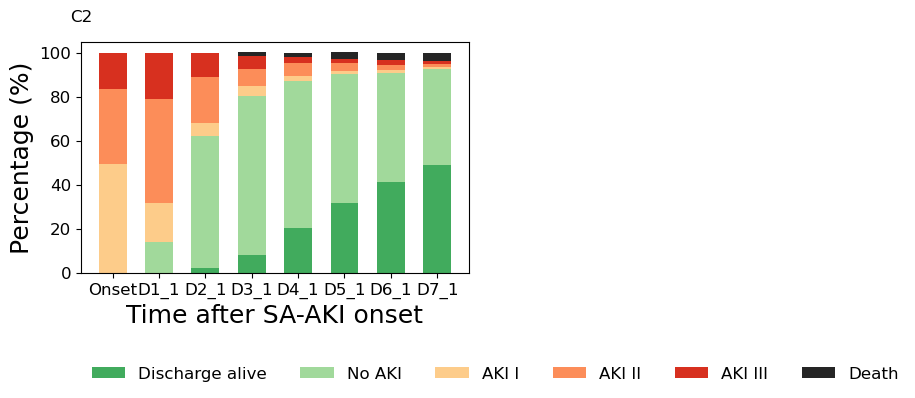

In [14]:
import numpy as npd
import matplotlib.pyplot as plt

plt.figure(figsize=(5,3)) 
ind = df_aki_all_.time.unique().tolist()
ind = sorted(range(len(ind)))
plt.xticks(ind, xticks)

df = df2
AKI0 = np.array(df[df["aki_stage"]==0]["percent"].tolist())
AKI1 = np.array(df[df["aki_stage"]==1]["percent"].tolist())
AKI2 = np.array(df[df["aki_stage"]==2]["percent"].tolist())
AKI3 = np.array(df[df["aki_stage"]==3]["percent"].tolist())
Died = np.array(df[df["aki_stage"]==4]["percent"].tolist())
alive = np.array(df[df["aki_stage"]==5]["percent"].tolist())

width = 0.6  
p0 = plt.bar(ind, alive, width=width, color ='#41ab5d') #  '#a1d99b'
p1 = plt.bar(ind, AKI0,bottom=alive, width = width, color='#a1d99b')  # '#e5f5e0'
p2 = plt.bar(ind, AKI1, width=width, bottom=alive+ AKI0,color='#fdcc8a')  
p3 = plt.bar(ind, AKI2, width=width, bottom=alive + AKI0 + AKI1,color='#fc8d59')
p4 = plt.bar(ind, AKI3, width=width, bottom=alive + AKI0 + AKI1 + AKI2,color='#d7301f')
p5 = plt.bar(ind, Died, width=width, bottom=alive + AKI0 + AKI1 + AKI2 + AKI3,color='#252525') ##a63603

plt.legend((p0[0], p1[0], p2[0], p3[0], p4[0], p5[0]), ('Discharge alive','No AKI', 'AKI I', 'AKI II', 'AKI III','Death'),
           bbox_to_anchor=(0.01,-0.5),loc = 3, borderaxespad=0,ncol=6,frameon=False,fontsize=12)
plt.title('C2',x=0,y=1.05)
plt.xlabel("Time after SA-AKI onset",fontsize=18) # (6h windows)
plt.ylabel("Percentage (%)",fontsize=18)
plt.yticks(np.arange(0, 110, 20),fontsize=12)
plt.xticks(fontsize=12)
plt.savefig('./result/eICU_C2_AKIstages.pdf', bbox_inches = 'tight')
plt.show()


/home/hanl/miniconda3/envs/mytensor/lib/python3.9/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


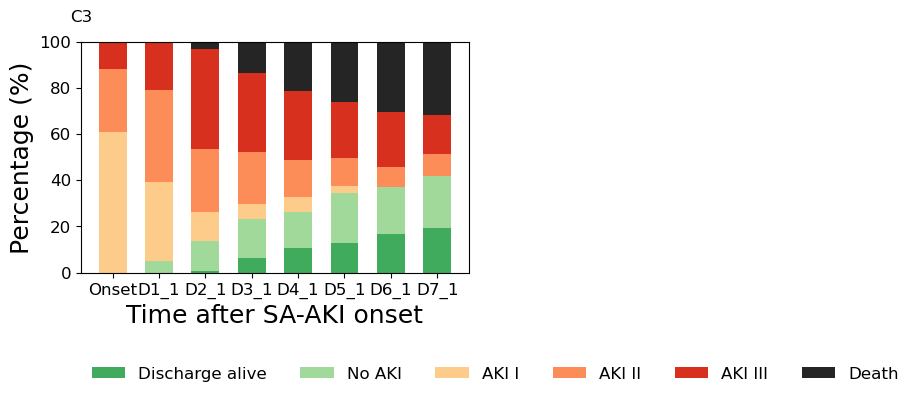

In [15]:
import numpy as npd
import matplotlib.pyplot as plt

plt.figure(figsize=(5,3)) 
ind = df_aki_all_.time.unique().tolist()
ind = sorted(range(len(ind)))
plt.xticks(ind, xticks)

df = df3
AKI0 = np.array(df[df["aki_stage"]==0]["percent"].tolist())
AKI1 = np.array(df[df["aki_stage"]==1]["percent"].tolist())
AKI2 = np.array(df[df["aki_stage"]==2]["percent"].tolist())
AKI3 = np.array(df[df["aki_stage"]==3]["percent"].tolist())
Died = np.array(df[df["aki_stage"]==4]["percent"].tolist())
alive = np.array(df[df["aki_stage"]==5]["percent"].tolist())

width = 0.6  
p0 = plt.bar(ind, alive, width=width, color ='#41ab5d') #  '#a1d99b'
p1 = plt.bar(ind, AKI0,bottom=alive, width = width, color='#a1d99b')  # '#e5f5e0'
p2 = plt.bar(ind, AKI1, width=width, bottom=alive+ AKI0,color='#fdcc8a')  
p3 = plt.bar(ind, AKI2, width=width, bottom=alive + AKI0 + AKI1,color='#fc8d59')
p4 = plt.bar(ind, AKI3, width=width, bottom=alive + AKI0 + AKI1 + AKI2,color='#d7301f')
p5 = plt.bar(ind, Died, width=width, bottom=alive + AKI0 + AKI1 + AKI2 + AKI3,color='#252525') ##a63603

plt.legend((p0[0], p1[0], p2[0], p3[0], p4[0], p5[0]), ('Discharge alive','No AKI', 'AKI I', 'AKI II', 'AKI III','Death'),
           bbox_to_anchor=(0.01,-0.5),loc = 3, borderaxespad=0,ncol=6,frameon=False,fontsize=12)
plt.title('C3',x=0,y=1.05)
plt.xlabel("Time after SA-AKI onset",fontsize=18) # (6h windows)
plt.ylabel("Percentage (%)",fontsize=18)
plt.yticks(np.arange(0, 110, 20),fontsize=12)
plt.xticks(fontsize=12)
plt.savefig('./result/eICU_C3_AKIstages.pdf', bbox_inches = 'tight')
plt.show()


/home/hanl/miniconda3/envs/mytensor/lib/python3.9/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


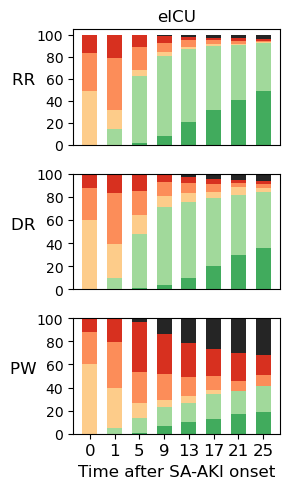

In [21]:
import numpy as np
import matplotlib.pyplot as plt

# Create subplots with 3 rows and 1 column
fig, axs = plt.subplots(3, 1, figsize=(3, 5), sharex=True)

for i, df in enumerate([ df2,df1, df3]):
    ind = df_aki_all_.time.unique().tolist()
    ind = sorted(range(len(ind)))

    AKI0 = np.array(df[df["aki_stage"]==0]["percent"].tolist())
    AKI1 = np.array(df[df["aki_stage"]==1]["percent"].tolist())
    AKI2 = np.array(df[df["aki_stage"]==2]["percent"].tolist())
    AKI3 = np.array(df[df["aki_stage"]==3]["percent"].tolist())
    Died = np.array(df[df["aki_stage"]==4]["percent"].tolist())
    alive = np.array(df[df["aki_stage"]==5]["percent"].tolist())

    width = 0.6
    p0 = axs[i].bar(ind, alive, width=width, color='#41ab5d')
    p1 = axs[i].bar(ind, AKI0, bottom=alive, width=width, color='#a1d99b')
    p2 = axs[i].bar(ind, AKI1, width=width, bottom=alive + AKI0, color='#fdcc8a')
    p3 = axs[i].bar(ind, AKI2, width=width, bottom=alive + AKI0 + AKI1, color='#fc8d59')
    p4 = axs[i].bar(ind, AKI3, width=width, bottom=alive + AKI0 + AKI1 + AKI2, color='#d7301f')
    p5 = axs[i].bar(ind, Died, width=width, bottom=alive + AKI0 + AKI1 + AKI2 + AKI3, color='#252525')

    axs[0].set_ylabel("RR   ", fontsize=12,rotation=0)
    axs[1].set_ylabel("DR   ", fontsize=12,rotation=0)
    axs[2].set_ylabel("PW   ", fontsize=12,rotation=0)
    axs[i].set_yticks(np.arange(0, 110, 20), fontsize=12)
    axs[0].set_title("eICU")
    axs[i].set_xticks([])
    axs[0].tick_params(axis='x', which='both', bottom=False)
    axs[1].tick_params(axis='x', which='both', bottom=False)
        
plt.xlabel("Time after SA-AKI onset", fontsize=12)
#plt.ylabel("Percentage (%)")
plt.xticks(ind, select_time_lst, fontsize=12)
# plt.legend((p0[0], p1[0], p2[0], p3[0], p4[0], p5[0]),
#                   ('Discharge alive', 'No AKI', 'AKI I', 'AKI II', 'AKI III', 'Death'),
#                   bbox_to_anchor=(0.01, 3.5), loc=3, borderaxespad=0, ncol=6, frameon=False)
plt.subplots_adjust(hspace=0.01)
plt.tight_layout()

plt.savefig('./result/eICU_Combined_AKIstages.png', bbox_inches='tight', dpi=300)
plt.savefig('./result/eICU_Combined_AKIstages.pdf', bbox_inches='tight', dpi=300)
# plt.savefig('./result/legend_AKIstages.pdf', bbox_inches='tight', dpi=300)
plt.show()
